<a href="https://colab.research.google.com/github/zakaria-aabbou/Big_data/blob/main/Projet_BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Projet BIG DATA</center>
<br>
<h3> M2 MLDS/AMSD - 2021-2022

**Réalisé par:**




*   AABBOU Zakaria





## Contexte et objectifs

Lorsque les données sont très volumineuses, il n’est plus possible d’appliquer des
méthodes qui supposent de les avoir toutes en mémoire en même temps sur une seule
machine.

Le but de ce projet est de voir plusieures méthodes qui visent le même objectif :
classifier des points de manière non supervisée. K-means est choisi comme objet
d’étude. Chaque partie correspond à une manière de l’implémenter, aucune n’est
universellement meilleure que les autres puisque chacune fait des choix différents pour
répondre à certaines contraintes.

# Installation : 

In [1]:
!pip install apache-beam

     ---------------------------------------- 4.5/4.5 MB 10.6 MB/s eta 0:00:00
     ------------------------------------- 612.2/612.2 kB 18.8 MB/s eta 0:00:00
     ---------------------------------------- 3.6/3.6 MB 17.8 MB/s eta 0:00:00
     ------------------------------------- 437.2/437.2 kB 13.8 MB/s eta 0:00:00
     ------------------------------------- 394.3/394.3 kB 12.4 MB/s eta 0:00:00
     -------------------------------------- 152.0/152.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 96.6/96.6 kB ? eta 0:00:00
     ---------------------------------------- 89.7/89.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.9/47.9 kB ? eta 0:00:00
     ------------------------------------- 198.7/198.7 kB 12.6 MB/s eta 0:00:00
  Preparing 


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install apache-beam[interactive]

# Libraries :

In [ ]:
import math
import csv
import pandas as pd
import time
import numpy as np
import collections
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import apache_beam as beam
from apache_beam import pvalue
from apache_beam import Create, FlatMap, Map, ParDo, Flatten, Partition
from apache_beam import Values, CoGroupByKey
from apache_beam import pvalue, window, WindowInto
from apache_beam.transforms import trigger

from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib

import time
import numpy as np
import random

#**A. Implémentation de k-means séquentiel (Python)**

## génération du jeu de données :

On va générer un jeu de données consistant en des points répartis en deux classes. On va générer une première classe de 100 points répartis à
proximité d’un centroïde de coordonnées (5, 5) et une autre classe où 100 points
sont autour des coordonnées (10, 10). apres on enregistre ces données dans un fichier au format CSV.

In [ ]:
# génération des données en utilisant comme centroides " moyenne" 5 et 10 avec une marge de 3 
# on peut faire des tests sur plusieurs datasets en changeant les parametres : 
data_set1 = np.random.normal(5, 1, size=(100, 2))   # classe de 100 points répartis à proximité d’un centroïde de coordonnées (5, 5)
data_set2 = np.random.normal(10, 1, size=(100, 2))  # classe où 100 points sont autour des coordonnées (10, 10)

In [ ]:
data = np.concatenate([data_set1, data_set2]) # concaténer les deux ensembles de points afin de les visualiser

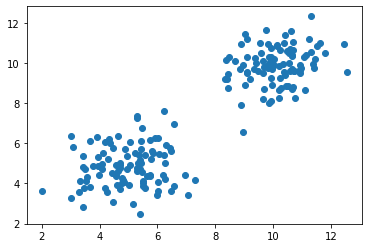

In [ ]:
plt.scatter(data[:,0],data[:,1]) # visualiser les données

In [ ]:
np.savetxt('data.csv',data, delimiter=',') # Enregistrer les données dans un fichier au format CSV.

In [ ]:
# Avec cette fonction, les données peuvent être converties dans un format compressé (string to float)
def transform_csv_data(string):
    val = string.split(",")
    for i, x in enumerate(val):
        val[i] = float(x)
    return val

In [ ]:
# Cette fonction sera appliquée et nous lirons les données et afficherons les informations de temps et de mémoire avec %%time
%%time
import csv
with open('data.csv', 'r', newline='') as file:
    rows = file.readlines()
    for row in rows:
        print(transform_csv_data(row))

[5.440181239854546, 6.091191836301112]
[4.189456491959004, 3.7896665750166507]
[5.030309523566708, 3.915606811356205]
[3.955869476759772, 4.868273287623368]
[3.7591853957796757, 4.8910541162097525]
[7.291047333063579, 4.158599250372483]
[4.9409969921868555, 4.7007063016472745]
[5.049759698405416, 4.907877732276096]
[6.459228926944457, 5.600662360770788]
[5.065242648697913, 6.05123004710965]
[5.814865537389385, 5.5962022643638765]
[5.761916041578479, 5.2126804661172335]
[6.23788324830425, 5.427099595533988]
[6.211783394236591, 7.622093911417196]
[4.857305724530571, 4.092524600120603]
[5.514812288171289, 3.8886468798226033]
[6.281466182627461, 5.935494621068395]
[4.770098849757492, 4.003769571805323]
[4.450301760327099, 3.0964700170312733]
[5.560483863457799, 3.79275175895198]
[4.693831450889075, 4.7836486037537576]
[3.557157769779969, 4.303957801080653]
[5.3236681686311895, 5.038748202562152]
[4.7924796645026095, 4.292816960912219]
[4.882217150741421, 5.718006055953211]
[3.4232555738809

Nous remarquons que nous avons consommé peu de mémoire

In [ ]:
# on va stocker les données dans un objet numpy array
data=[]
with open('data.csv', 'r', newline='') as file:
    rows = file.readlines()
    for i, row in enumerate(rows):
        data.append(transform_csv_data(row))

In [ ]:
data = np.array(data) # les données sont stockées dans "data"

## fonctions du séquentiel k-means:

Maintenant on va implémenter l'algorithme k-means séquentiel en Python

In [ ]:
# Cette fonction permet de trouver le centre le plus proche de chaque point x_i
def centre_plus_proche_de_xi(centres,x):
    u = np.argmin([np.linalg.norm(x- i) for i in centres])
    return u

In [ ]:
# Fonction qui permet de faire la mise à jour de centre µ et l’effectif  :
def mise_a_jours(centre,effectif,x):
    centre += (1/(effectif+1))*(x- centre)
    effectif += 1
    return centre, effectif

In [ ]:
# Implémentation de l'algorithme k-means séquentiel
def sequentiel_kmeans(k,data):
    centroids=[]

    #initialisation des centres : 
    centre_idx = np.random.randint(low = 0, high = len(data), size = k, dtype = 'int16')
    for i in range(len(centre_idx)):
        centroids.append(data[centre_idx[i]])
    
    #initialisation du nombre d'effectifs pour chanque classe : 
    effectif_k= np.repeat(1, k)
    #classes : 
    labels = np.repeat(np.nan, len(data)).astype('int8')
    labels[centre_idx] = np.array(range(k), dtype='int8')

    data = [x for i, x in enumerate(data) if i not in centre_idx ]
    # classification de la donnée : 
    for i, x in enumerate(data):
        # nearest center : 
        u = centre_plus_proche_de_xi(centroids,x)
        labels[i]= u 

        # Mise à jour des paramètres :
        centroids[u], effectif_k[u]= mise_a_jours(centroids[u],effectif_k[u],x)

    return labels
    

## Application du séquentiel k-means : 

In [ ]:
predicted_lables = sequentiel_kmeans(k= 2, data= data )

In [ ]:
predicted_lables

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0], dtype=int8)

In [ ]:
# Générer de vrais labels :
true_labels =np.repeat([0, 1], 100)

In [ ]:
accuracy_score(predicted_lables,true_labels) # Calculer la précision en comparant les labels réelles avec les labels prédites

0.99

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

#fonction de visualisation des données avec les labels de classification
def eval_clustering_2D(x, labels, pred_labels):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle("clustering results , NMI : "+ str(nmi(labels,pred_labels))) # pour calculer la valeur de NMI
    ax1.scatter(x[:,0], x[:,1],
                c=labels, edgecolor='none', alpha=1,)
    ax2.scatter(x[:,0], x[:,1],
                c=pred_labels, edgecolor='none', alpha=1,)

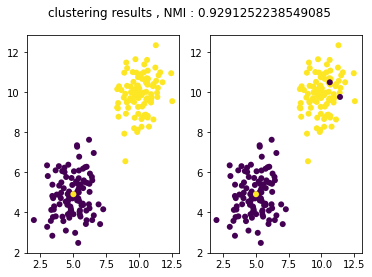

In [ ]:
eval_clustering_2D(data , true_labels ,predicted_lables)

# **Partie B : Implémentation d’une version streaming de k-means(Python)**

L’implémentation séquentielle de k-means souffre d’un inconvénient : si la distribution
des données change au cours du temps (concept drift), les centres se déplacent et
l’affectation aux clusters n’est alors plus toujours cohérente. Reboucler sur les données
permet d’atténuer cet effet. Dans cette partie, une autre solution est proposée. Elle
permet de s’affranchir de reboucler sur toutes les données en conservant en mémoire
un sous-ensemble des données : les dernières arrivées.

**Hyper-paramètres** : Soit T le nombre maximum de batches à garder en mémoire, et un
paramètre r qui contrôle le poids à accorder à l’historique (plus il est grand, moins les
anciens batches pèseront dans la contribution aux centres).

**Entrées** : X l’ensemble des batches précédents partitionnés par P (aléatoire si il n’y a pas
de batch précédent), et B⁰ le nouveau batch.

**Algorithme :**


*   Si la taille de X est T : enlever le plus vieux batch de X
*   Ajouter B⁰ à X
*   Initialiser les centroïdes C avec la partition P
*    Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :
    - les points des batches sont pondérés par r^t où t est le numéro du batch
ordonné par ordre décroissant : 0 est le batch le plus récent, 1 est le batch
précédent, etc.
    - utiliser l’argument sample_weight de la méthode fit de
l’implémentation k-means de scikit-learn :
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit 

**Sortie:** l’ensemble des centroïdes C et la partition associée P.


In [ ]:
# Hyper-paramètres :
T = 5
r = 5

In [ ]:
# calculer le poids pour les points de chaque batch
def weight(X):
    w = []
    ordre = 0
    for i in reversed(X):
        for j in i:
            w.append(r/(ordre+1))
        ordre += 1
    return list(reversed(w))

# Implémentation de streaming de k-means
def streaming_k_means(X,B):
    X= list(X)
    print(X)
    if len(X) == T:
        del X[0] # Remove the oldest batch from X
    X.append(B)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.concatenate(X), y=None, sample_weight=weight(X))
    C = kmeans.cluster_centers_
    P = kmeans.labels_
    return C,P

In [ ]:
# Tester l'algorithme
# Entrées :
X = []
Batches = [
           ((0,0), (1,1), (10,10)),
           ((15,17), (2,7)),
           ((3,4), (10,4)),
           ((22,5), (12,9)),
           ((16,1), (1,6))
           ]
P = [(random.randint(0,len(Batches[0])-1)) for k in range(len(Batches[0]))]


for idx, B in enumerate(Batches):
    C,P = streaming_k_means(X, B)
    print(f'Les centres sont : {C}')
    print(f'La partition est : {P}')

[]
Les centres sont : [[ 0.5  0.5]
 [10.  10. ]]
La partition est : [0 0 1]
[]
Les centres sont : [[15. 17.]
 [ 2.  7.]]
La partition est : [0 1]
[]
Les centres sont : [[ 3.  4.]
 [10.  4.]]
La partition est : [0 1]
[]
Les centres sont : [[22.  5.]
 [12.  9.]]
La partition est : [0 1]
[]
Les centres sont : [[16.  1.]
 [ 1.  6.]]
La partition est : [0 1]


# **Partie C : Implémentation de k-means `distribué` "Apache Beam"**

Pour cette partie, on pourra dans un premier temps se placer en dimension 1 (une
seule coordonnée par point)

## Question 1 : Créer une PCollection qui contient l’ensemble des points.

In [ ]:
import apache_beam.runners.interactive.interactive_beam as ib
# Nous allons créer une liste de dimension 1 avec des valeurs comprises entre 0 et 10
with beam.Pipeline() as pipeline:
  collection = (
      pipeline
      | 'Créer une liste avec tous les éléments en 1 dimension' >> beam.Create([(random.uniform(0,10))for x in range(200)])
  )
  collection | beam.Map(print)

8.244086608514928
2.6080872933433485
3.178315766057065
6.168997264154079
4.270835830552841
2.8367273612624535
9.825761997139749
7.942453095168571
6.242385116031687
3.784491256653264
4.540885920268374
6.652174048854674
1.7505814818685728
8.095437948500521
0.4490132094451449
8.10957751230843
2.639020860678425
5.89985758169545
0.16657246056147712
9.623279162527524
9.0151029748403
6.410074564662231
8.861255193035808
6.056712003669389
9.457779543977434
2.239510242337992
0.18421664589207576
9.686355086658207
8.821178510406368
1.5955525847284302
5.7878201794497395
3.2931711084292203
9.474729306662576
2.848421149321311
2.4065704524579323
8.878629948040047
1.363039374364211
3.2390320770008074
6.443909965424916
3.1726856965955985
5.141738197988916
3.539953649748435
9.082538017297233
6.949888412574206
8.517005833533084
6.212568273958846
7.564600251165228
6.951471576822357
6.716368041594527
3.425263745246674
2.5381839146165976
5.408480345147665
3.516732287380732
6.164386132496393
4.949536672679821

## Question 2 : Pour l’initialisation, transformer la PCollection précédente pour que chaque élément de la nouvelle PCollection soit un tuple où :


*   a. le premier élément est le numéro de cluster choisi aléatoirement ;
*   b. le second élément du tuple soit les coordonnées du point.

In [ ]:
import apache_beam.runners.interactive.interactive_beam as ib

with beam.Pipeline() as pipeline:
  collection = (
      pipeline
      | 'Créer une liste avec tous les éléments en 1 dimension' >> beam.Create([(random.uniform(0,10)) for x in range(200)])
      | 'Ajouter un cluster aléatoire' >> beam.Map(lambda x: (random.randint(0,10),x))
  )
  collection | beam.Map(print)

(10, 6.37695124141199)
(8, 7.996981827606152)
(0, 2.5321014470932734)
(5, 7.087542859391528)
(10, 2.955032407769581)
(5, 1.3493254551234657)
(5, 4.0128345420266465)
(5, 6.61387225874007)
(9, 2.994948228983574)
(3, 8.239146629896556)
(7, 1.2602955432118157)
(8, 6.009742751573621)
(2, 3.7658150064518447)
(3, 5.119367601626445)
(6, 0.4203780336456575)
(3, 2.9791840890133736)
(8, 0.8993339947746348)
(9, 6.071538454682583)
(5, 2.805638090009616)
(2, 1.741536485057198)
(8, 3.7846262128243335)
(3, 7.608676838729797)
(0, 3.5867222355927986)
(3, 4.947243303905861)
(6, 5.594728024598855)
(9, 6.157824645094765)
(10, 6.072592555194908)
(5, 9.649119949376532)
(0, 4.572712622089446)
(10, 5.428877527012327)
(3, 1.8152997319493736)
(2, 9.677311064920541)
(1, 6.742449150095227)
(7, 4.232691002179269)
(9, 7.176595658632669)
(2, 4.158872212832099)
(5, 6.543706494135203)
(7, 6.5476820907511275)
(0, 2.0674745226508584)
(7, 3.167833708487786)
(2, 0.436290109577947)
(5, 6.422079440473931)
(2, 5.9152912909368

## Question 3 : Implémenter l’étape de calcul des centres : Une PCollection nommée centroids sera créée pour ça. Chaque élément sera un tuple (numéro de cluster, coordonnées du centroïde).

In [ ]:
def centers(element):
    clust = element[0]
    liste = element[1]
    return (clust,sum(liste)/len(liste))

In [ ]:
import apache_beam.runners.interactive.interactive_beam as ib

with beam.Pipeline() as pipeline:
  centroids = (
      pipeline
      | 'Créer une liste avec tous les éléments en 1 dimension' >> beam.Create([random.uniform(0,10) for x in range(200)])
      | 'Ajouter un cluster aléatoire' >> beam.Map(lambda x: (random.randint(0,10),x))
      | 'ID de cluster de groupe' >> beam.GroupByKey()
      | 'Calculer la moyenne du cluster ' >> beam.Map(centers)
      
  )
  centroids | beam.Map(print) 

(4, 5.167897938892947)
(3, 4.495803863096906)
(5, 5.231568272606937)
(9, 5.118130370835517)
(7, 4.5370233384127285)
(1, 5.376830759166946)
(6, 5.636732040766578)
(0, 6.067599395076768)
(10, 3.7164366799055206)
(8, 4.654400009031565)
(2, 5.693413595847051)


## Question 4 : Implémenter l’étape de partitionnement 

* a. Créer une fonction assign_cluster qui prend deux entrées :
    - i. un point (ses coordonnées)
    - ii. un dictionnaire de centroïdes où la clé correspond au numéro de cluster et la valeur correspond aux coordonnées du centroïde.

La fonction retourne un tuple avec :

    - le numéro du cluster le plus proche du point ;
    - les coordonnées du point.
* b. Assigner à chaque point son numéro de cluster :
    - i. Utiliser la méthode Map avec les centroïdes comme entrée complémentaire sous forme de dictionnaire : https://beam.apache.org/documentation/transforms/python/elementwise/map/#example-8-map-with-side-inputs-as-dictionaries
    - ii. Quelle supposition fait-on pour passer les centroïdes sous cette forme ? Peut-on optimiser cette étape ? Si oui, modifier l’implémentation de l’étape de partitionnement pour pallier ça. 

#### Creation de la fonction assign_cluster

In [ ]:
def assign_clusterd(point, medoids):

    test_point = np.array(point)
    dist = []
    for i in medoids:
        # calc distance point is from every cluster
        dist[i] = np.linalg.norm(test_point - medoids[i])

    # determine which cluster was closest
    #dist = [dist0,dist1,dist2,dist3,dist4,dist5,dist6]
    cluster = np.where(dist == min(dist))[0]
    #logging.info("*** Cluster = %s", str(dist))

    yield ("cluster", cluster)
    return cluster , test_point

In [ ]:
class assign_cluster(beam.DoFn):

    def process(self, element):

        #test_point = array([0.397, 0.1, 0.426, 0.0, 0.434, 0.541])
        test_point = np.array(element)

        # medoid points between 0 and 1
        medoids = np.array(
                [[0.102, 0.2, 0.43, 0.0, 0.297, 0.124],
                [0.248, 0.1, 0.346, 0.125, 0.173, 0.564],
                [0.491, 0.6, 0.568, 0.375, 0.355, 0.589],
                [0.529, 0.1, 0.526, 0.375, 0.446, 0.544],
                [0.473, 0.2, 0.434, 0.0, 0.118, 0.311],
                [0.611, 0.0, 0.672, 0.875, 0.418, 0.81],
                [0.397, 0.1, 0.426, 0.0, 0.434, 0.541]])

        # calc distance point is from every cluster
        dist0 = np.linalg.norm(test_point - medoids[0])
        dist1 = np.linalg.norm(test_point - medoids[1])
        dist2 = np.linalg.norm(test_point - medoids[2])
        dist3 = np.linalg.norm(test_point - medoids[3])
        dist4 = np.linalg.norm(test_point - medoids[4])
        dist5 = np.linalg.norm(test_point - medoids[5])
        dist6 = np.linalg.norm(test_point - medoids[6])

        # determine which cluster was closest
        dist = [dist0,dist1,dist2,dist3,dist4,dist5,dist6]
        cluster = np.where(dist == min(dist))[0]
        #logging.info("*** Cluster = %s", str(dist))

        yield ("cluster", cluster)

In [ ]:
coord_list = [0.397, 0.1, 0.426, 0.0, 0.434, 0.541]

In [ ]:
with beam.Pipeline() as pipeline:
  # la PCollection
  data_set = ( pipeline |  beam.Create(coord_list) |  beam.Map( lambda x: ((np.random.randint(0, 2)), x) ) )
  centroids = ( # Calculer les centroides
      data_set  | beam.GroupByKey()
            | beam.MapTuple(lambda cluster, points: (cluster, np.mean(points)))
  )


In [ ]:
with beam.Pipeline() as pipeline:
  coord_x = ( pipeline  |beam.Create(coord_list) )
  clustering = ( #Affectation 
      coord_x
      |  beam.ParDo(assign_cluster())
    #   |  beam.Map( assign_clusterd, centroids = beam.pvalue.AsDict(centroids))
      |  beam.Map(print)
  )

('cluster', array([2]))
('cluster', array([0]))
('cluster', array([2]))
('cluster', array([0]))
('cluster', array([2]))
('cluster', array([2]))


# **Partie D : Implémentation du `séquentiel` k-means en utilisant "apache beam"**

In [ ]:
from apache_beam.transforms.userstate import BagStateSpec
k = 2
class KMeansSeq(beam.DoFn):
    state1 = BagStateSpec(name='myCenters', coder=beam.coders.PickleCoder())
    state2 = BagStateSpec(name='myN', coder=beam.coders.PickleCoder())
    
    def process(self, element, myCenters=beam.DoFn.StateParam(state1), myN=beam.DoFn.StateParam(state2)):
        key, value = element
        n = myN.read()
        centers = myCenters.read()
        i = 0
        for x in n:
            i+=1
        if i<k:
            myCenters.add(value)
            myN.add(1)
            yield i
        else:  
            dmin = float('inf')
            nearest = 0 
            for near, c in enumerate(centers):
                d = np.linalg.norm(x-c)
                if d < dmin:
                    dmin = d
                    nearest = near
            
            #Mise à jour du center et l'effectif par classe
            new_centers = list(centers)
            new_n = list(n)
            new_centers[nearest] = new_centers[nearest] + (1/(new_n[nearest]+1))*(element[1]-new_centers[nearest])
            new_n[nearest] = new_n[nearest]+1
            myN.clear()
            myCenters.clear()
            for c1 in new_centers:
                myCenters.add(c1)
            for n1 in new_n:
                myN.add(n1)
            yield nearest

In [ ]:
#Pipeline
with beam.Pipeline() as pipeline:
   classes = (
      pipeline
      | 'Coordinates' >> beam.Create(data)
      | 'Random clusters' >> beam.Map(lambda x: (0, x))
      | 'Clustering' >> beam.ParDo(KMeansSeq())
    )
   classes | beam.io.WriteToText(file_path_prefix='centers')

In [ ]:
y=[]
with open('/content/centers-00000-of-00001', 'r', newline='') as file:
  rows = file.readlines()
for i, row in enumerate(rows):
  y.append(int(row))

In [ ]:
# generate true labels : 
true_labelsE =np.repeat([0, 1], 100)
accuracy_score(y,true_labelsE)

0.475

# **Partie E : Implémentation d’une version streaming et distribuée de k-means (Apache Beam)**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from apache_beam.transforms.userstate import ReadModifyWriteStateSpec
from apache_beam.transforms.userstate import CombiningValueStateSpec


class MyClass2(beam.DoFn):

  data = BagStateSpec(name='data',coder=beam.coders.PickleCoder())
  cent = BagStateSpec(name='cent',coder=beam.coders.PickleCoder())
  def process(self, element,
              data=beam.DoFn.StateParam(data),
              cent=beam.DoFn.StateParam(cent),
              ):
    
    key,value = element

    #lecture des états
    X = list(data.read())
    centers = list(cent.read())

    #initialiser les centres que pour la première fois 
    if(len(X) == 0):
      centers = []
      P0 = np.random.choice([0, 1], size=(10,), p=[0.5, 0.5])
      for k in range(0,2):
        c = []
        for i in range(0,len(P0)):
          if (i in np.where(P == k)[0].tolist()):
            c.append(value[i])
        center = [sum(sub_list) / len(sub_list) for sub_list in zip(*c)]
        centers.append(center)

    # if taille de X inferieur à T =5 on insère le batch
    if (len(X) < 5):
      data.add(value)
      X = list(data.read())

    #sinon on remplace le batch le plus ancien (premier de la liste)
    else:
      X.pop(0)
      X.append(value)
      data.clear()
      for x in X:
        data.add(x)
    
    #assembling data (liste de listes ==> liste de points)
    flat_data = [item for sublist in X for item in sublist]

    # vecteur de poids
    r_data = []
    for i in range(len(X)-1,-1,-1):
      r_batch = [r**i] * len(value)
      r_data.append(r_batch)
    flat_r_data = [item for sublist in r_data for item in sublist] 

    centers = np.asarray(centers).reshape((2,2))
    kmeans = KMeans(n_clusters=2,init=centers,n_init=1).fit(flat_data,sample_weight=flat_r_data)
    cent.clear()
    cent.add(kmeans.cluster_centers_)

    print("centers : ",kmeans.cluster_centers_)
    print("labels : ",kmeans.labels_)
    print("------------------------------------------------------------------------------------")

    yield kmeans.cluster_centers_ , kmeans.labels_

In [ ]:
# Hyper-paramètres :
T = 5
r = 5
Batches2 = [
           ((0,0), (1,1)),
           ((15,17), (2,7),),
           ((3,4), (10,4)),
           ((22,5), (12,9))
           ]

In [ ]:
with beam.Pipeline() as pipeline:
  data = (
    pipeline
    | "Create" >> beam.Create(Batches2)
  )
  (data
    | 'Add key' >> beam.Map(lambda x: (0,(x)))
    | "Kmeans streaming et distribuée" >> beam.ParDo(MyClass2())
  )

centers :  [[0. 0.]
 [1. 1.]]
labels :  [0 1]
------------------------------------------------------------------------------------
centers :  [[ 0.63636364  1.09090909]
 [15.         17.        ]]
labels :  [0 0 1 0]
------------------------------------------------------------------------------------
centers :  [[ 0.84210526  1.19298246]
 [15.         17.        ]]
labels :  [0 0 1 0 0 0]
------------------------------------------------------------------------------------
centers :  [[ 0.84210526  1.19298246]
 [15.14814815 16.25925926]]
labels :  [0 0 1 0 0 0 1 1]
------------------------------------------------------------------------------------
